<a href="https://colab.research.google.com/github/KukovecRok/AlexNet_inefficient_using_NiaPy/blob/main/AlexNetDiplomskaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predpogoj - mount gDrive

In [ ]:
# Nujno potrebno za dostop do datotek iz gDrivea
from google.colab import drive
drive.mount('/content/gdrive') # Preverjanje pristnosti.. 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Potrebni importi
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import argparse
import PIL.Image
import pandas as pd
import glob
from pathlib import Path
import time
from numpy import asarray

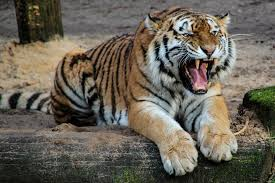

In [ ]:
from IPython.display import Image, display
display(Image('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')) # Slika iz https://phys.org/news/2019-11-indian-authorities-exaggerated-tiger.html

## Prikaz random slike iz množice

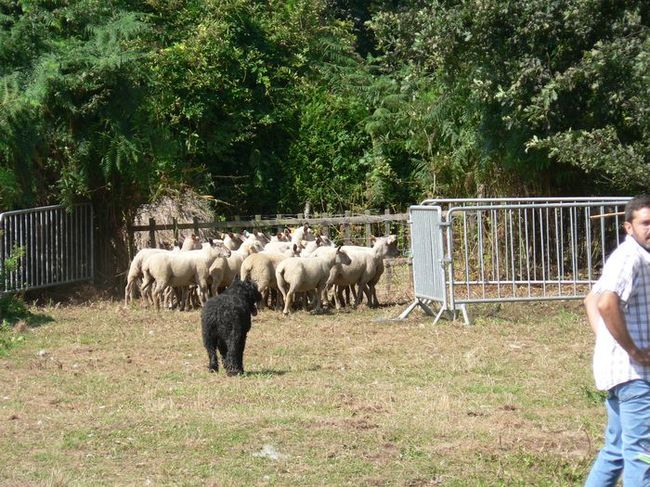

In [ ]:
import random, os
# Prikaz nakljucne slike
path = "/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/"
random_file = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
Image('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+random_file)

## Funkcija napovejSlike

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

def napovejSlike(slika, alexnet):
   # Obdelava velikosti slike
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),       # Nastavi velikost sičic 224x224
        transforms.ToTensor(),              # Input na Tensorjev format
        transforms.Normalize( # Normalizacija
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])
    # Odpiranje slik
    transformed_img = data_transforms(slika) # Klicanje funkcije za obdelavo velikosti slik(e)
    batch_img = torch.unsqueeze(transformed_img, 0)
    
    output = alexnet(batch_img)

    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0 
    
    return indices, percentage

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Izboljsana napoved - vse slike v mapi
CasZacetek = time.time()

df = None
if df is not None:
    df = df.drop(['SlicicaNo.','Dejansko','Napovedano','PoNiaPy','Tocnost'], axis=1, errors='ignore')

#images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/*.jpg")
images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/*.JPEG")
podatki = []
for image in images:
   with open(image, 'rb') as file:
        img = PIL.Image.open(file)
        indices, percentage = napovejSlike(img, alexnet)
        i = 0
        with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]

            podatki.append({
                'Slicica No.': (Path(file.name).stem)[20:],
                'Napovedano':  results[0][0],
                'PoNiaPy' : ['Sledi'],
                'Tocnost' : results[0][1],
                'ImeDatoteke' : (Path(file.name).stem + ".JPEG")
            })

            #print("\nTop 5 napovedanih razredov")
            #for i in range(5):
                #print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

df = pd.DataFrame(data=podatki)
df.sort_values(by='Tocnost', ascending=False, inplace=True)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
print("Trajanje: ", trajanje)
# Merjenje časa - CPU 71 sekund ; GPU 301; TPU 338 - nekaj ni ok..


Naš napovedan razred: lifeboat 
Algoritem to trdi z zagotovostvjo 99.94%

Naš napovedan razred: colobus, colobus monkey 
Algoritem to trdi z zagotovostvjo 90.25%

Naš napovedan razred: Staffordshire bullterrier, Staffordshire bull terrier 
Algoritem to trdi z zagotovostvjo 27.14%

Naš napovedan razred: jaguar, panther, Panthera onca, Felis onca 
Algoritem to trdi z zagotovostvjo 39.40%

Naš napovedan razred: tiger, Panthera tigris 
Algoritem to trdi z zagotovostvjo 65.72%

Naš napovedan razred: German short-haired pointer 
Algoritem to trdi z zagotovostvjo 47.54%

Naš napovedan razred: Australian terrier 
Algoritem to trdi z zagotovostvjo 95.59%

Naš napovedan razred: Bouvier des Flandres, Bouviers des Flandres 
Algoritem to trdi z zagotovostvjo 98.80%

Naš napovedan razred: kit fox, Vulpes macrotis 
Algoritem to trdi z zagotovostvjo 77.95%

Naš napovedan razred: English setter 
Algoritem to trdi z zagotovostvjo 92.40%

Naš napovedan razred: red fox, Vulpes vulpes 
Algoritem to trdi z

50.47249674797058

## Slike iz ILSVRC2010
Model se je na njih izkazal za zelo uspešnega

Tukaj imamo tabelo imen datotek ter kategorij, v katero spadajo

In [ ]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/ID,Ime,Kategorija.csv", sep=";", index_col=0) 
df1.sample(5) 

,ImeDatoteke,Kategorija
ID_Kategorija,,
102,ILSVRC2010_val_00049658.JPEG,lentil
751,ILSVRC2010_val_00004319.JPEG,volleyball
232,ILSVRC2010_val_00044241.JPEG,"China tree, false dogwood, jaboncillo, chinabe..."
323,ILSVRC2010_val_00009097.JPEG,"nymphalid, nymphalid butterfly, brush-footed b..."
713,ILSVRC2010_val_00046738.JPEG,"hipflask, pocket flask"


## Skupne kategorije
* 634
* Kategorije v preseku, ki jih zna napovedatovat tale AlexNet in slike iz ILSVRC2010
* Validacijska množica ni uporabljena za učenje, rezultati bodo verjetno višji kot pri testni, kar je v mojem primeru tudi smiselno
* Velika točnost pred NiaPy, nato pa nekaj popolnoma drugega za "enako" sliko..

In [ ]:
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/BothKategorije.csv", sep=";", index_col=0) 
print(len(df2))

634


## Predpripravljena tabela 
* stolpec NiaPy se bo napolnil kasneje

In [ ]:
# Združevanje za dejanske kategorije
df = df.merge(df1, how='inner', on='ImeDatoteke')
# Brisanje praznih (v df1 je 50.000 vrstic - celotna _val množica slik)
df.dropna(inplace=True)
# Združevanje iz dataframera samo skupnih kategorij --> Inner join odstrani vse primerke, ki jih naš model ne zna napovedat
df = df.merge(df2, how='inner', on='Kategorija')
# Preimenovanje stolpca
df = df.rename(columns={"Kategorija": "Dejanska_kategorija"})
# Zamenjava vrstnega reda stolpcev
df = df[['Slicica No.','Dejanska_kategorija','Napovedano','PoNiaPy','Tocnost','ImeDatoteke']]
df.sort_values(by=['Tocnost'], ascending=False).head(10)
# Dolžina df = 636, kar se sklada s številom različnih imen datotek, katerih kategorije zna napovedat
# V driveu je 1000 slik, vseh kategorij je ~1600, naš AlexNet jih zna napovedat ~2/3 = 1000. 
# Slike so randomly vendar konsistentno poimenovane, ~2/3 * 1000 = ~ 640, torej bo najverjetneje držalo

,Slicica No.,Dejanska_kategorija,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


In [ ]:
col_one_list = df['ImeDatoteke'].tolist()
col_one_list.sort()
# Število različnih imen datotek = 637 - Nekatere kategorije so podvojene (različne slike spadajo v enako kategorijo)
len(col_one_list)

637

## Tabela napačno napovedanih

In [ ]:
dfNapacni = df[~df['Dejanska_kategorija'].isin(df['Napovedano'])]
dfNapacni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
262,977,otter,badger,[Sledi],90.782722,ILSVRC2010_val_00000977.JPEG
300,855,"bakery, bakeshop, bakehouse",trifle,[Sledi],87.583458,ILSVRC2010_val_00000855.JPEG
305,415,trimaran,catamaran,[Sledi],86.632568,ILSVRC2010_val_00000415.JPEG
312,193,screwdriver,nail,[Sledi],85.336342,ILSVRC2010_val_00000193.JPEG
329,704,"green lizard, Lacerta viridis","American chameleon, anole, Anolis carolinensis",[Sledi],82.166084,ILSVRC2010_val_00000704.JPEG
337,155,partridge,"ruffed grouse, partridge, Bonasa umbellus",[Sledi],79.790627,ILSVRC2010_val_00000155.JPEG
343,344,cliff dwelling,"sloth bear, Melursus ursinus, Ursus ursinus",[Sledi],78.339355,ILSVRC2010_val_00000344.JPEG
397,353,"artichoke, globe artichoke",cardoon,[Sledi],70.422104,ILSVRC2010_val_00000353.JPEG
416,975,tiger cat,"tiger, Panthera tigris",[Sledi],65.720871,ILSVRC2010_val_00000975.JPEG
263,728,otter,"red-backed sandpiper, dunlin, Erolia alpina",[Sledi],65.469543,ILSVRC2010_val_00000728.JPEG


## Tabela pravilno napovedanih

In [ ]:
dfPravilni = df[df['Dejanska_kategorija'].isin(df['Napovedano'])] #dfPravilni = df.loc[df['Dejanska_kategorija'] == df['Napovedano']] # Drugačna sintaksa za isto stvar
dfPravilni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


## Statistika nad ILSVRC2010_val_\*\*\*\*****.JPEG

In [ ]:
pravilno_napovedani = len(df.index) - len(dfNapacni.index)
print("Vsi napovedani: " + str(len(df.index)) + "\nPravilno napovedani: " + str(pravilno_napovedani) +"\nNapacno napovedani: " + str(len(dfNapacni.index)))
Tocnost = (pravilno_napovedani / len(df.index)* 100)
print("Tocnost: %.4f"% Tocnost+"%")

Vsi napovedani: 637
Pravilno napovedani: 535
Napacno napovedani: 102
Tocnost: 83.9874%


In [ ]:
# Napoved 1 slike
slika = 'ILSVRC2010_val_00000857.JPEG'
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: baseball 
Algoritem to trdi z zagotovostvjo 100.00%


In [ ]:
!pip install NiaPy==2.0.0rc12

     |████████████████████████████████| 225kB 8.5MB/s 
     |████████████████████████████████| 829kB 13.7MB/s 
     |████████████████████████████████| 174kB 26.4MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4b0a199501ff97080bf22bd0176d2ac863f22fae0957000ff24fa84c053ca997
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for openpyxl: filename=openpyxl-3.0.3-py2.py3-none-any.whl size=241261 sha256=bd33f63b918306aea4afee3ba37c809aa137a891493d6b454e65163af7952877
  Stored in directory: /root/.cache/pip/wheels/b5/85/ca/e768ac132e57e75e645a151f8badac71cc0089e7225dddf76b
Successfully built future openpyxl
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


# NiaPy 
Prva ideja je po vzoru TestBenchmark.py, ustvarit array podoben "iskanje = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]"
* Pretvorba slike v 1d array
* Standardizacija (vsaka vrednost v arrayu / 255)
* Izvajanje NiaPy
* Pretvorba napovedanih vredenosti nazaj v vrednosti med 1 - 255 ( * 255)
* Pretvorba 1d arraya v sliko
* Prikaz slike, primerjava..
### Prihaja do napake pri pretvorbi ( i / 255 ; i * 255 ) 
* Sumim .reshape ( np.asarray(flat_arr).reshape(prvotenShape) )

In [110]:
import cv2
from google.colab.patches import cv2_imshow

def imgTO1d(img):
    oblika = img.shape
    img = img.reshape(-1)
    testko = [i / 255 for i in img] # Shrani prvoten shape slike
    return oblika, testko

def imgFROM1d(testko, oblika):
    testkoDva = [int(i * 255) for i in testko]
    testkoDva = asarray(testkoDva)
    testkoDva = testkoDva.reshape(oblika)
    return testkoDva

## Trenutna slika
* samo 1
* bejzbol.jpeg ( original : "ILSVRC2010_val_00000857.JPEG" )
* pomanjašana v 160x160
* testiranje delovanja pretvorbe in NiaPy

In [ ]:
# Napoved 1 slike
#slika = 'ILSVRC2010_val_00000857.JPEG'
slika = 'bejzbol.JPEG'
slika = 'tiger.jpg'
#with open('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+slika, 'rb') as file:
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: tiger, Panthera tigris 
Algoritem to trdi z zagotovostvjo 91.64%


In [144]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanje):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanje = iskanje

    def function(self):
        def evaluate(D, solution):
            # print(f'D: {D}')
            # print(f'solution: {solution}')

            razlika = 0
            for i in range(D):
                razlika = razlika + abs(iskanje[i] - solution[i])

            return razlika

        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')
    #originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol.JPEG')

    oblika, iskanjeSlika = imgTO1d(originalSlika)

    algoritem = ParticleSwarmAlgorithm(NP=20)  

    n = len(iskanjeSlika)
    rangeFor = (int(n / 9))

    test = np.empty(n, dtype=object)
    iskanje = np.empty(9, dtype=object)
    
    for i in range(rangeFor):
        i *= 9
        for j in range (9):
            iskanje[j] = iskanjeSlika[i+j]
    
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                            nFES=50,
                            optType=OptimizationType.MINIMIZATION,
                            benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)
        for j in range (9):
            test[i+j] = resitev[j]

    print("ISKANJE: ", iskanje)
    print("resitev: ", resitev)
    print("fitness: ", fitness)
    # Celotna slika --> 1d array pri NP=10.000 in nFES=100.000: "Vaša seja se je zrušila, ko ste porabili ves razpoložljivi RAM. ", rezultat pa zanič, priložen v GitHubu

ISKANJE:  [0.10588235294117647 0.24705882352941178 0.12941176470588237
 0.14901960784313725 0.3215686274509804 0.1607843137254902
 0.2901960784313726 0.4627450980392157 0.30980392156862746]
resitev:  [0.37668836 0.2475622  0.20842899 0.17575838 0.1985742  0.57009518
 0.17219887 0.5552657  0.2858336 ]
fitness:  1.1438588146812383


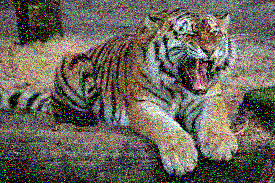

Naš napovedan razred: stone wall 
Algoritem to trdi z zagotovostvjo 17.53%


In [145]:
poskusDva = imgFROM1d(test, oblika)
cv2_imshow(poskusDva)

PIL_image = PIL.Image.fromarray(np.uint8(poskusDva)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    # Top 5 razredov po verjetnosti napovedi
    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

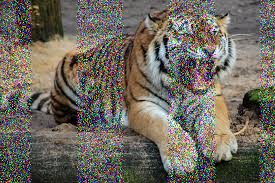

Naš napovedan razred: sock 
Algoritem to trdi z zagotovostvjo 11.14%


In [146]:
# Spreminjanje samo dela slike?
originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')

oblika, iskanjeSlika = imgTO1d(originalSlika)

algoritem = ParticleSwarmAlgorithm(NP=10)  

n = len(iskanjeSlika)
rangeFor = (int(n / 9))

test = np.empty(n, dtype=object)
iskanje = np.empty(9, dtype=object)
    
for i in range(rangeFor):
    i *= 9
    for j in range (9):
        iskanje[j] = iskanjeSlika[i+j]
    if ( ( (i % 275) > 0) & ( (i % 275) < 90) | ( (i % 275) < 275) & ( (i % 275) > 225) ):
        benchm = TestBenchmark(iskanje=iskanje)
        task = StoppingTask(D=len(iskanje),
                          nFES=20,
                          optType=OptimizationType.MINIMIZATION,
                          benchmark=benchm)

        resitev, fitness = algoritem.run(task=task)

        for j in range (9):
            test[i+j] = resitev[j]
    else:
        for j in range (9):
            test[i+j] = iskanjeSlika[i+j]

poskusDva = imgFROM1d(test, oblika)
cv2_imshow(poskusDva)

PIL_image = PIL.Image.fromarray(np.uint8(poskusDva)).convert('RGB')

indices, percentage = napovejSlike(PIL_image, alexnet)
with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
    classes = [i.strip() for i in labels.readlines()]

    results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
    print('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')